#Install packages

In [474]:
# !pip install pandas numpy matplotlib seaborn scikit-learn

# Import Libraries

In [475]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

# Set style for Visualization

In [476]:
models = {}
scaler = StandardScaler()
label_encoders = {}
best_model = None
feature_names = []

In [477]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [478]:
def load_and_explore_data(file_path):
        """Load dataset and perform initial exploration"""
        print("=" * 120)
        print("PERSONALITY PREDICTION MODEL - DATA EXPLORATION")
        print("=" * 120)

        # Load data
        df = pd.read_csv(file_path)
        print(f"Dataset loaded successfully!")
        print(f"Shape: {df.shape}")
        print("\nFirst few rows:")
        print(df.head())

        print("\nDataset Info:")
        print(df.info())

        print("\nMissing values:")
        print(df.isnull().sum())

        print("\nTarget variable distribution:")
        print(df['Personality'].value_counts())

        return df


In [479]:
df= load_and_explore_data("/content/drive/MyDrive/Personality_folder/personality_dataset.csv")

PERSONALITY PREDICTION MODEL - DATA EXPLORATION
Dataset loaded successfully!
Shape: (2900, 8)

First few rows:
   Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0               4.0         No                      4.0            6.0   
1               9.0        Yes                      0.0            0.0   
2               9.0        Yes                      1.0            2.0   
3               0.0         No                      6.0            7.0   
4               3.0         No                      9.0            4.0   

  Drained_after_socializing  Friends_circle_size  Post_frequency Personality  
0                        No                 13.0             5.0   Extrovert  
1                       Yes                  0.0             3.0   Introvert  
2                       Yes                  5.0             2.0   Introvert  
3                        No                 14.0             8.0   Extrovert  
4                        No                  8.0 

# Create comprehensive data visualizations

In [480]:
def visualize_data(df):
    # Set up the plotting area
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Personality Prediction - Data Analysis', fontsize=16, fontweight='bold', y=1.02)

    # 1. Target distribution
    df['Personality'].value_counts().plot(kind='bar', ax=axes[0,0], color=['#E74C3C', '#3498DB'])
    axes[0,0].set_title('Personality Distribution')
    axes[0,0].set_xlabel('Personality Type')
    axes[0,0].set_ylabel('Count')
    axes[0,0].tick_params(axis='x', rotation=45)

    # 2. Time spent alone distribution
    sns.boxplot(data=df, x='Personality', y='Time_spent_Alone', ax=axes[0,1], palette=['#E74C3C', '#3498DB'])
    axes[0,1].set_title('Time Spent Alone by Personality')

    # 3. Friends circle size distribution
    sns.boxplot(data=df, x='Personality', y='Friends_circle_size', ax=axes[0,2], palette=['#E74C3C', '#3498DB'])
    axes[0,2].set_title('Friends Circle Size by Personality')

    # 4. Stage fear distribution
    stage_fear_counts = pd.crosstab(df['Stage_fear'], df['Personality'])
    stage_fear_counts.plot(kind='bar', ax=axes[1,0], color=['#E74C3C', '#3498DB'])
    axes[1,0].set_title('Stage Fear by Personality')
    axes[1,0].tick_params(axis='x', rotation=45)

    # 5. Social event attendance
    sns.boxplot(data=df, x='Personality', y='Social_event_attendance', ax=axes[1,1], palette=['#E74C3C', '#3498DB'])
    axes[1,1].set_title('Social Event Attendance by Personality')

    # 6. Going outside frequency
    sns.boxplot(data=df, x='Personality', y='Going_outside', ax=axes[1,2], palette=['#E74C3C', '#3498DB'])
    axes[1,2].set_title('Going Outside Frequency by Personality')

    # 7. Drained after socializing
    drained_counts = pd.crosstab(df['Drained_after_socializing'], df['Personality'])
    drained_counts.plot(kind='bar', ax=axes[2,0], color=['#E74C3C', '#3498DB'])
    axes[2,0].set_title('Drained After Socializing by Personality')
    axes[2,0].tick_params(axis='x', rotation=45)

    # 8. Post frequency
    sns.boxplot(data=df, x='Personality', y='Post_frequency', ax=axes[2,1], palette=['#E74C3C', '#3498DB'])
    axes[2,1].set_title('Post Frequency by Personality')

    # 9. Correlation heatmap
    # First encode categorical variables for correlation
    df_encoded = df.copy()
    le_stage = LabelEncoder()
    le_drained = LabelEncoder()
    le_personality = LabelEncoder()

    df_encoded['Stage_fear_encoded'] = le_stage.fit_transform(df_encoded['Stage_fear'])
    df_encoded['Drained_after_socializing_encoded'] = le_drained.fit_transform(df_encoded['Drained_after_socializing'])
    df_encoded['Personality_encoded'] = le_personality.fit_transform(df_encoded['Personality'])

    # Select numeric columns for correlation
    numeric_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
                    'Friends_circle_size', 'Post_frequency', 'Stage_fear_encoded',
                    'Drained_after_socializing_encoded', 'Personality_encoded']

    corr = df_encoded[numeric_cols].corr()
    sns.heatmap(corr, annot=True, cmap='RdBu_r', center=0, ax=axes[2,2])
    axes[2,2].set_title('Feature Correlation Matrix')

    plt.tight_layout()
    plt.show()

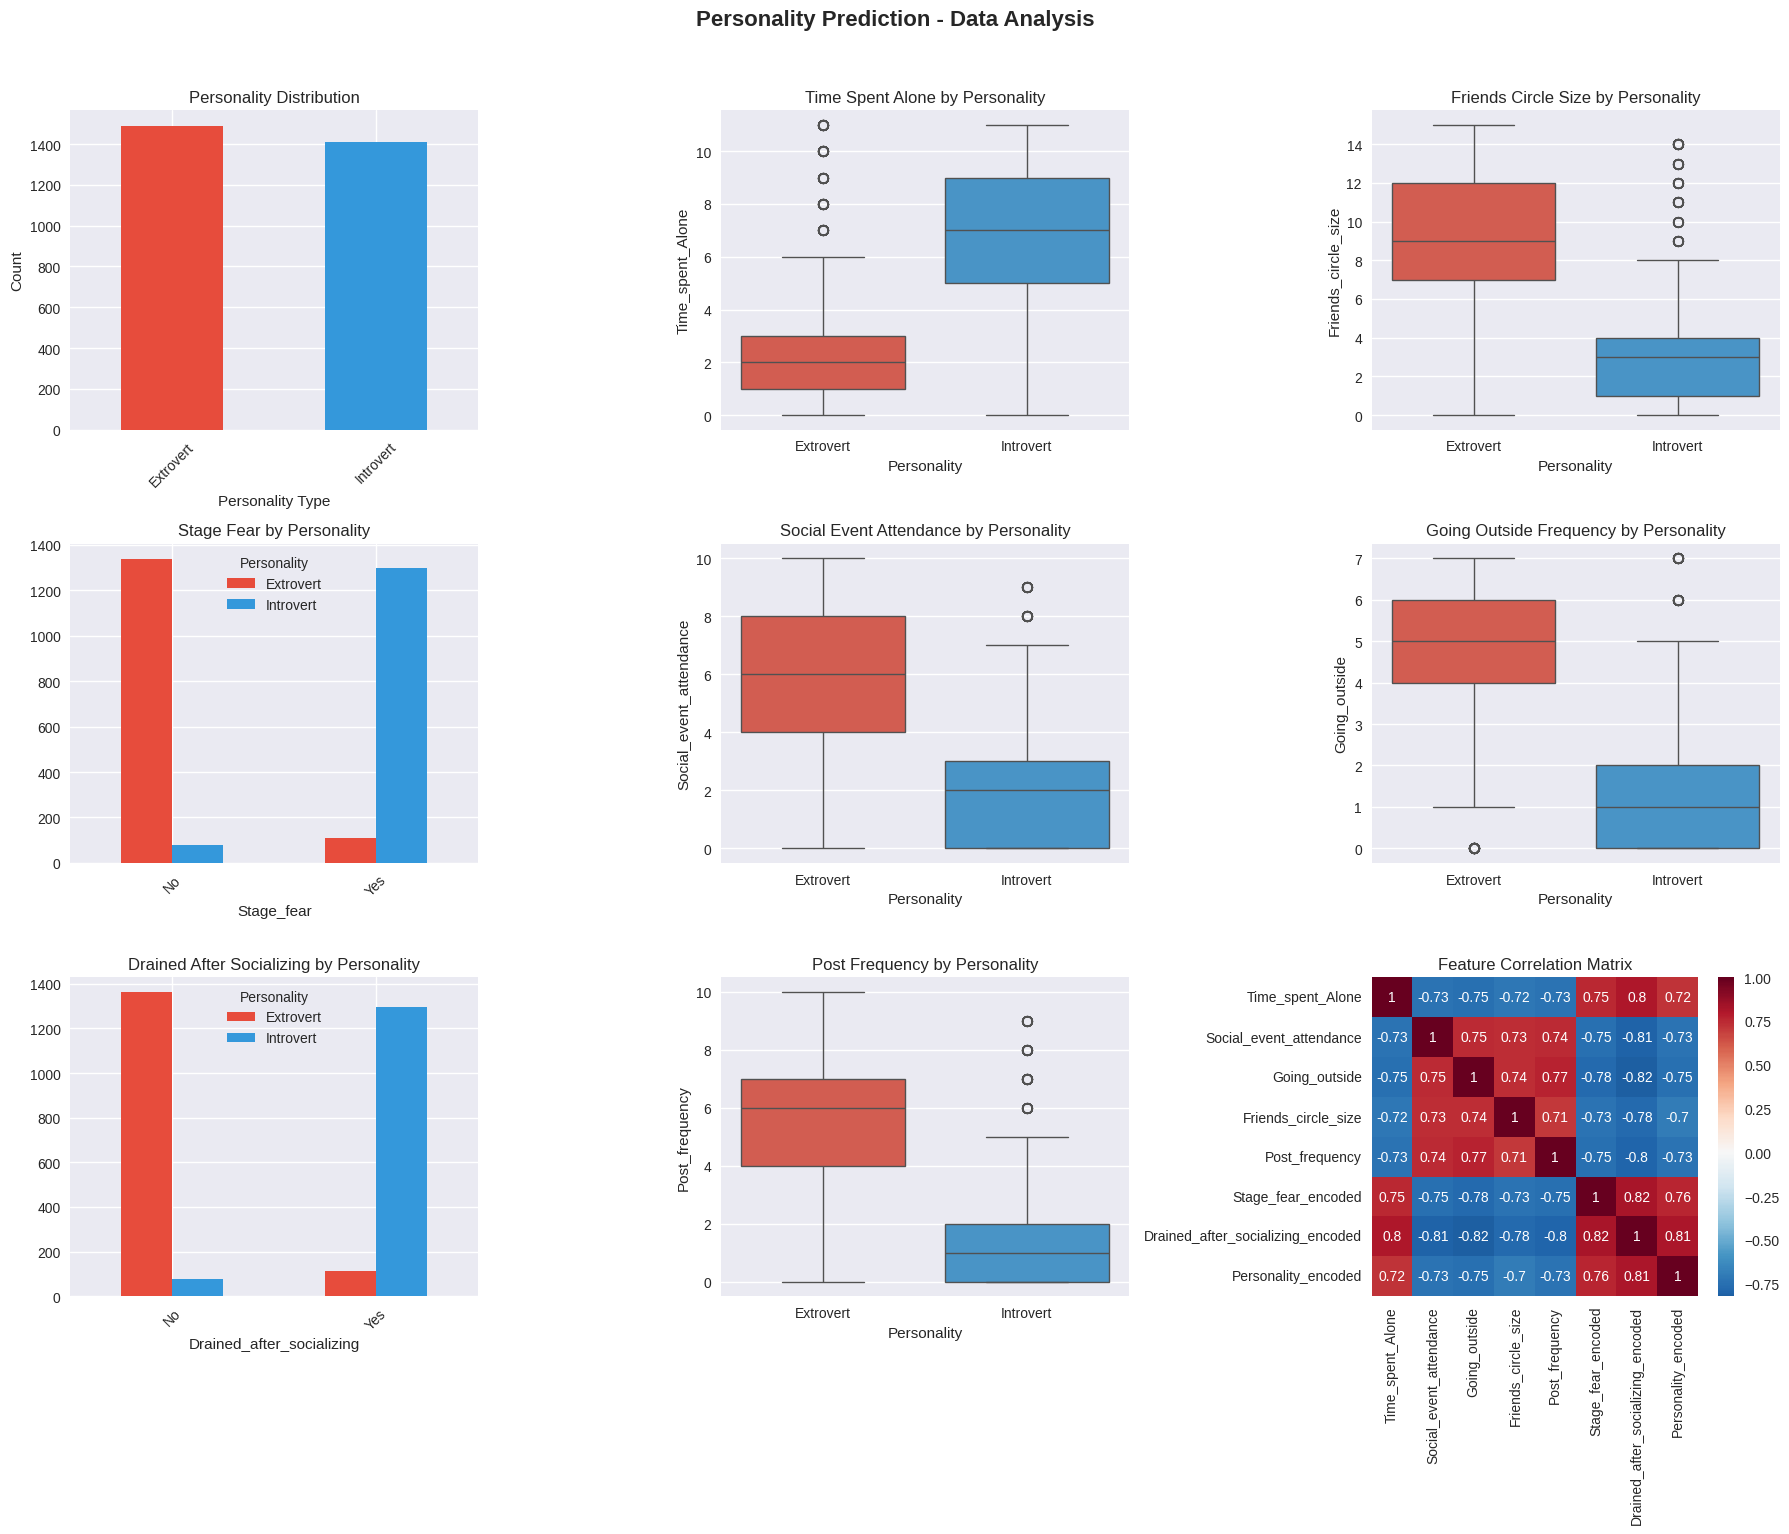

In [481]:
visualize_data(df)

# Preprocess the data for machine learning

In [482]:
def preprocess_data(df):
    print("\n" + "=" * 120)
    print("DATA PREPROCESSING")
    print("=" * 120)

    # Initialize preprocessing objects
    scaler = StandardScaler()
    label_encoders = {}

    # Create a copy of the dataframe
    df_processed = df.copy()

    # Check for missing values before processing
    print("Missing values per column:")
    missing_values = df_processed.isnull().sum()
    if missing_values.any():
        print(missing_values[missing_values > 0])
    else:
        print("No missing values found.")

    # Handle missing values
    # For numerical columns, fill with median
    numerical_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
                     'Friends_circle_size', 'Post_frequency']

    for col in numerical_cols:
        if col in df_processed.columns and df_processed[col].isnull().any():
            median_value = df_processed[col].median()
            df_processed[col].fillna(median_value, inplace=True)
            print(f"Filled missing values in {col} with median: {median_value}")

    # For categorical columns, fill with mode (most frequent value)
    categorical_cols = ['Stage_fear', 'Drained_after_socializing', 'Personality']

    for col in categorical_cols:
        if col in df_processed.columns and df_processed[col].isnull().any():
            mode_value = df_processed[col].mode()[0] if not df_processed[col].mode().empty else 'Unknown'
            df_processed[col].fillna(mode_value, inplace=True)
            print(f"Filled missing values in {col} with mode: {mode_value}")

    # Validate required columns exist
    required_cols = numerical_cols + ['Stage_fear', 'Drained_after_socializing', 'Personality']
    missing_cols = [col for col in required_cols if col not in df_processed.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    # Handle categorical variables encoding
    categorical_encode_cols = ['Stage_fear', 'Drained_after_socializing']

    for col in categorical_encode_cols:
        if col in df_processed.columns:
            le = LabelEncoder()
            # Fit and transform the categorical column
            df_processed[col + '_encoded'] = le.fit_transform(df_processed[col])
            label_encoders[col] = le
            print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

    # Prepare features and target
    feature_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
                   'Friends_circle_size', 'Post_frequency', 'Stage_fear_encoded',
                   'Drained_after_socializing_encoded']

    # Check if all feature columns exist
    available_features = [col for col in feature_cols if col in df_processed.columns]
    if len(available_features) != len(feature_cols):
        missing_features = set(feature_cols) - set(available_features)
        print(f"Warning: Missing feature columns: {missing_features}")
        feature_cols = available_features

    X = df_processed[feature_cols].copy()
    feature_names = feature_cols

    # Final check for NaN values in features
    if X.isnull().any().any():
        print("Remaining NaN values in features:")
        print(X.isnull().sum())
        # Drop rows with remaining NaN values
        nan_rows = X.isnull().any(axis=1)
        print(f"Dropping {nan_rows.sum()} rows with NaN values")
        X = X.dropna()
        df_processed = df_processed.loc[X.index]

    # Encode target variable
    if 'Personality' in df_processed.columns:
        le_target = LabelEncoder()
        y = le_target.fit_transform(df_processed.loc[X.index, 'Personality'])
        label_encoders['Personality'] = le_target
        print(f"Target encoding: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")
    else:
        raise ValueError("Target column 'Personality' not found in dataset")

    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")

    # Verify data consistency
    if len(X) != len(y):
        raise ValueError(f"Feature and target length mismatch: {len(X)} vs {len(y)}")

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale the features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Feature names: {feature_names}")

    return X_train, y_train, X_test, y_test, X_train_scaled, X_test_scaled, scaler, label_encoders, feature_names


In [483]:
X_train, y_train, X_test, y_test, X_train_scaled, X_test_scaled, scaler, label_encoders, feature_names = preprocess_data(df)


DATA PREPROCESSING
Missing values per column:
Time_spent_Alone             63
Stage_fear                   73
Social_event_attendance      62
Going_outside                66
Drained_after_socializing    52
Friends_circle_size          77
Post_frequency               65
dtype: int64
Filled missing values in Time_spent_Alone with median: 4.0
Filled missing values in Social_event_attendance with median: 3.0
Filled missing values in Going_outside with median: 3.0
Filled missing values in Friends_circle_size with median: 5.0
Filled missing values in Post_frequency with median: 3.0
Filled missing values in Stage_fear with mode: No
Filled missing values in Drained_after_socializing with mode: No
Encoded Stage_fear: {'No': np.int64(0), 'Yes': np.int64(1)}
Encoded Drained_after_socializing: {'No': np.int64(0), 'Yes': np.int64(1)}
Target encoding: {'Extrovert': np.int64(0), 'Introvert': np.int64(1)}
Features shape: (2900, 7)
Target shape: (2900,)
Training set: 2320 samples
Test set: 580 samples

# Train multiple machine learning models

In [484]:
def train_models(X_train, y_train, X_test, y_test, X_train_scaled, X_test_scaled):
  print("\n" + "=" * 120)
  print("MODEL TRAINING")
  print("=" * 120)

  # Define models
  models = {
      'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
      'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
      'SVM': SVC(random_state=42, probability=True),
      'Gradient Boosting': GradientBoostingClassifier(random_state=42),
      'Decision Tree': DecisionTreeClassifier(random_state=42)
  }

  # Train and evaluate each model
  results = {}

  for name, model in models.items():
      print(f"\nTraining {name}...")

      # Use scaled data for models that benefit from it
      if name in ['Logistic Regression', 'SVM']:
          model.fit(X_train_scaled, y_train)
          y_pred = model.predict(X_test_scaled)
          y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
      else:
          model.fit(X_train, y_train)
          y_pred = model.predict(X_test)
          y_pred_proba = model.predict_proba(X_test)[:, 1]

      # Calculate metrics
      accuracy = accuracy_score(y_test, y_pred)
      auc_score = roc_auc_score(y_test, y_pred_proba)

      # Cross-validation
      if name in ['Logistic Regression', 'SVM']:
          cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
      else:
          cv_scores = cross_val_score(model, X_train, y_train, cv=5)

      results[name] = {
          'model': model,
          'accuracy': accuracy,
          'auc': auc_score,
          'cv_mean': cv_scores.mean(),
          'cv_std': cv_scores.std(),
          'predictions': y_pred,
          'probabilities': y_pred_proba
      }

      print(f"Accuracy: {accuracy:.4f}")
      print(f"AUC Score: {auc_score:.4f}")
      print(f"CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

  models = results

  # Select best model based on cross-validation score
  best_model_name = max(results.keys(), key=lambda x: results[x]['cv_mean'])
  best_model = results[best_model_name]['model']
  best_model_name = best_model_name

  print(f"\nBest Model: {best_model_name}")
  print(f"Best CV Score: {results[best_model_name]['cv_mean']:.4f}")
  return models, best_model_name, best_model, y_test

In [485]:
models, best_model_name, best_model, y_test = train_models(X_train, y_train, X_test, y_test, X_train_scaled, X_test_scaled)


MODEL TRAINING

Training Random Forest...
Accuracy: 0.8983
AUC Score: 0.9478
CV Score: 0.9280 (+/- 0.0111)

Training Logistic Regression...
Accuracy: 0.9052
AUC Score: 0.9211
CV Score: 0.9315 (+/- 0.0137)

Training SVM...
Accuracy: 0.9172
AUC Score: 0.9473
CV Score: 0.9388 (+/- 0.0044)

Training Gradient Boosting...
Accuracy: 0.9172
AUC Score: 0.9598
CV Score: 0.9384 (+/- 0.0065)

Training Decision Tree...
Accuracy: 0.8569
AUC Score: 0.8666
CV Score: 0.8767 (+/- 0.0137)

Best Model: SVM
Best CV Score: 0.9388


# Comprehensive model evaluation

In [486]:
def evaluate_models(models, best_model_name, best_model, y_test, X_test, feature_names=None, label_encoders=None, scaler=None):
    print("\n" + "=" * 120)
    print("MODEL EVALUATION")
    print("=" * 120)

    # Create evaluation plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Model Evaluation Results', fontsize=16, fontweight='bold')

    # 1. Model comparison - Blue and Red bars
    model_names = list(models.keys())
    accuracies = [models[name]['accuracy'] for name in model_names]
    cv_scores = [models[name]['cv_mean'] for name in model_names]

    x = np.arange(len(model_names))
    width = 0.35

    axes[0,0].bar(x - width/2, accuracies, width, label='Test Accuracy', alpha=0.8, color='#E74C3C')  # Red
    axes[0,0].bar(x + width/2, cv_scores, width, label='CV Score', alpha=0.8, color='#3498DB')      # Blue
    axes[0,0].set_xlabel('Models')
    axes[0,0].set_ylabel('Score')
    axes[0,0].set_title('Model Performance Comparison')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(model_names, rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 2. ROC Curves - Blue and Red gradient palette
    roc_colors = ['#D4B85A', '#85C1E9', '#5D6D7E', '#F48FB1', '#7DCEA0']  # Light Gold, Light Blue, Light Dark Blue, Light Pink, Light Green
    color_idx = 0

    for name in model_names:
        # Check if probabilities exist for this model
        if 'probabilities' in models[name]:
            fpr, tpr, _ = roc_curve(y_test, models[name]['probabilities'])
            auc_score = models[name]['auc']
            color = roc_colors[color_idx % len(roc_colors)]
            axes[0,1].plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', color=color, linewidth=2)
            color_idx += 1

    axes[0,1].plot([0, 1], [0, 1], color='#95A5A6', linestyle='--', alpha=0.7, linewidth=2)
    axes[0,1].set_xlabel('False Positive Rate')
    axes[0,1].set_ylabel('True Positive Rate')
    axes[0,1].set_title('ROC Curves')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # 3. Confusion Matrix for best model - Blue to Red colormap
    # Check if the best_model_name exists in models and has predictions
    if best_model_name in models and 'predictions' in models[best_model_name]:
        cm = confusion_matrix(y_test, models[best_model_name]['predictions'])
    else:
        # If predictions don't exist, generate them
        print(f"Generating predictions for {best_model_name}...")
        y_pred = best_model.predict(X_test)  # Now X_test is available as parameter
        cm = confusion_matrix(y_test, y_pred)
        # Store the predictions for future use
        if best_model_name not in models:
            models[best_model_name] = {}
        models[best_model_name]['predictions'] = y_pred

    sns.heatmap(cm, annot=True, fmt='d', cmap='RdBu_r', ax=axes[1,0])  # Red-Blue colormap
    axes[1,0].set_title(f'Confusion Matrix - {best_model_name}')
    axes[1,0].set_xlabel('Predicted')
    axes[1,0].set_ylabel('Actual')

    # 4. Feature Importance (for tree-based models) - Blue to Red gradient
    if hasattr(best_model, 'feature_importances_') and feature_names is not None:
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1]

        # Create blue to red gradient colors for feature importance bars
        n_features = len(importances)
        # Custom blue to red colormap
        from matplotlib.colors import LinearSegmentedColormap
        colors = ['#ff8f00', '#5DADE2', '#85C1E9', '#F1948A', '#E74C3C', '#C0392B']
        n_bins = 256
        cmap = LinearSegmentedColormap.from_list('blue_red', colors, N=n_bins)
        feature_colors = cmap(np.linspace(0, 1, n_features))

        axes[1,1].bar(range(len(importances)), importances[indices], color=feature_colors)
        axes[1,1].set_title(f'Feature Importance - {best_model_name}')
        axes[1,1].set_xlabel('Features')
        axes[1,1].set_ylabel('Importance')
        axes[1,1].set_xticks(range(len(importances)))
        axes[1,1].set_xticklabels([feature_names[i] for i in indices], rotation=45)
    else:
        axes[1,1].text(0.5, 0.5, f'{best_model_name} does not support\nfeature importance',
                       ha='center', va='center', transform=axes[1,1].transAxes,
                       fontsize=12, color='#2C3E50')  # Dark blue text
        axes[1,1].set_title('Feature Importance Not Available')
        axes[1,1].set_facecolor('#EBF5FB')  # Light blue background

    plt.tight_layout()
    plt.show()

    # Print detailed classification report for best model
    print(f"\nDetailed Classification Report - {best_model_name}:")
    print("=" * 50)

    # Get predictions for classification report
    if best_model_name in models and 'predictions' in models[best_model_name]:
        y_pred = models[best_model_name]['predictions']
    else:
        y_pred = best_model.predict(X_test)  # Now X_test is available as parameter

    if label_encoders is not None and 'Personality' in label_encoders:
        target_names = label_encoders['Personality'].classes_
        print(classification_report(y_test, y_pred, target_names=target_names))
    else:
        print(classification_report(y_test, y_pred))

    return best_model, best_model_name, scaler, label_encoders


MODEL EVALUATION


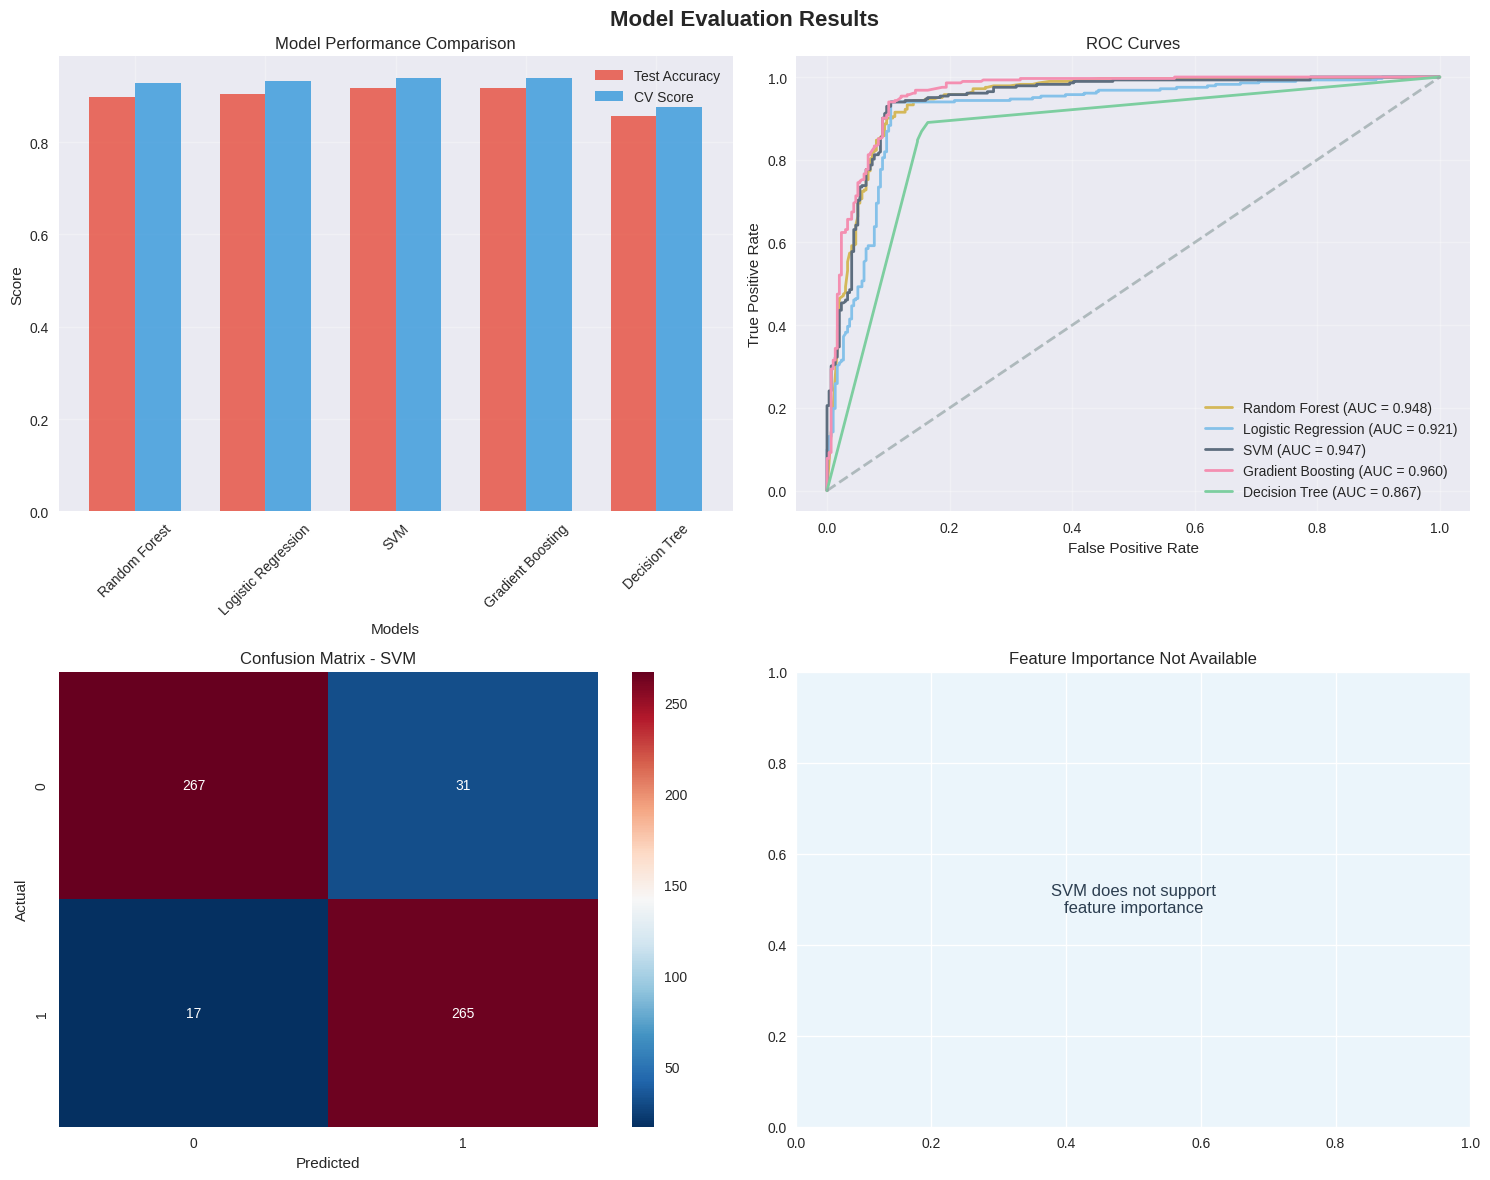


Detailed Classification Report - SVM:
              precision    recall  f1-score   support

   Extrovert       0.94      0.90      0.92       298
   Introvert       0.90      0.94      0.92       282

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580



In [487]:
best_model, best_model_name,scaler, label_encoders = evaluate_models(models, best_model_name, best_model, y_test, X_test, feature_names, label_encoders, scaler)

# Make predictions for new data

Features should be a dictionary with keys:
* Time_spent_Alone: float
* Social_event_attendance: float  
* Going_outside: float
* Friends_circle_size: int
* Post_frequency: float
* Stage_fear: 'Yes' or 'No'
* Drained_after_socializing: 'Yes' or 'No'

In [488]:
def predict_personality(features, best_model, best_model_name,scaler, label_encoders):

  # Encode categorical features
  stage_fear_encoded = label_encoders['Stage_fear'].transform([features['Stage_fear']])[0]
  drained_encoded = label_encoders['Drained_after_socializing'].transform([features['Drained_after_socializing']])[0]

  # Create feature array
  feature_array = np.array([[
      features['Time_spent_Alone'],
      features['Social_event_attendance'],
      features['Going_outside'],
      features['Friends_circle_size'],
      features['Post_frequency'],
      stage_fear_encoded,
      drained_encoded
  ]])

  # Scale features if needed
  if best_model_name in ['Logistic Regression', 'SVM']:
      feature_array = scaler.transform(feature_array)

  # Make prediction
  prediction = best_model.predict(feature_array)[0]
  probability = best_model.predict_proba(feature_array)[0]

  # Decode prediction
  personality = label_encoders['Personality'].inverse_transform([prediction])[0]

  return {
      'prediction': personality,
      'probability': {
          'Extrovert': probability[0],
          'Introvert': probability[1]
      }
  }


In [489]:
# Example 1: Typical introvert
example1 = {
    'Time_spent_Alone': 8.5,
    'Social_event_attendance': 2.0,
    'Going_outside': 1.5,
    'Friends_circle_size': 3,
    'Post_frequency': 1.0,
    'Stage_fear': 'Yes',
    'Drained_after_socializing': 'Yes'
}
result1 = predict_personality(example1, best_model,best_model_name, scaler, label_encoders)
print("Example 1 (Typical Introvert Profile):")
print(f"Features: {example1}")
print(f"Prediction: {result1['prediction']}")
print(f"Probabilities: Extrovert: {result1['probability']['Extrovert']:.3f}, Introvert: {result1['probability']['Introvert']:.3f}")

Example 1 (Typical Introvert Profile):
Features: {'Time_spent_Alone': 8.5, 'Social_event_attendance': 2.0, 'Going_outside': 1.5, 'Friends_circle_size': 3, 'Post_frequency': 1.0, 'Stage_fear': 'Yes', 'Drained_after_socializing': 'Yes'}
Prediction: Introvert
Probabilities: Extrovert: 0.071, Introvert: 0.929


In [490]:
# Example 2: Typical extrovert
example2 = {
    'Time_spent_Alone': 2.0,
    'Social_event_attendance': 8.5,
    'Going_outside': 7.0,
    'Friends_circle_size': 15,
    'Post_frequency': 8.0,
    'Stage_fear': 'No',
    'Drained_after_socializing': 'No'
}

result2 = predict_personality(example2, best_model,best_model_name, scaler, label_encoders)
print("\nExample 2 (Typical Extrovert Profile):")
print(f"Features: {example2}")
print(f"Prediction: {result2['prediction']}")
print(f"Probabilities: Extrovert: {result2['probability']['Extrovert']:.3f}, Introvert: {result2['probability']['Introvert']:.3f}")


Example 2 (Typical Extrovert Profile):
Features: {'Time_spent_Alone': 2.0, 'Social_event_attendance': 8.5, 'Going_outside': 7.0, 'Friends_circle_size': 15, 'Post_frequency': 8.0, 'Stage_fear': 'No', 'Drained_after_socializing': 'No'}
Prediction: Extrovert
Probabilities: Extrovert: 0.940, Introvert: 0.060


In [491]:
print("\n" + "=" * 120)
print("MODEL TRAINING COMPLETED SUCCESSFULLY!")
print(f"Best performing model: {best_model_name}")
print("We can now use predict_personality() function to make predictions on new data.")
print("=" * 120)


MODEL TRAINING COMPLETED SUCCESSFULLY!
Best performing model: SVM
We can now use predict_personality() function to make predictions on new data.
